In [1]:
import pandas, math
from matplotlib import pyplot as plt
%matplotlib inline

def GLoadIGC(fname):
    fin = open(fname, "rb")   # sometimes get non-ascii characters in the header
    IGCdatetime0 = None
    recs, tind = [ ], [ ]
    for l in fin:
        if l[:5] == b'HFDTE':    #  HFDTE090317
            l = l.decode("utf8") 
            IGCdatetime0 = pandas.Timestamp("20"+l[9:11]+"-"+l[7:9]+"-"+l[5:7])
        elif l[0] == ord("B"):   #  B1523345257365N00308169WA0030800393000
            utime = int(l[1:3])*3600+int(l[3:5])*60+int(l[5:7])
            latminutes1000 = int(l[7:9])*60000+int(l[9:11])*1000+int(l[11:14])
            lngminutes1000 = (int(l[15:18])*60000+int(l[18:20])*1000+int(l[20:23]))*(l[23]==ord('E') and 1 or -1) 
            s = int(l[35:]) if len(l) >= 40 else 0
            recs.append((latminutes1000/60000, lngminutes1000/60000, int(l[25:30]), int(l[30:35]), s, utime*1000))
            tind.append(IGCdatetime0 + pandas.Timedelta(seconds=utime))
            
    return pandas.DataFrame.from_records(recs, columns=["lat", "lng", "alt", "altb", "s", "u"], index=tind)



In [2]:
i1 = GLoadIGC("darrenbrown 2017-08-15 12_08_53.igc")
i2 = GLoadIGC("JulianTodd 2017-08-15 12_22_13.igc")


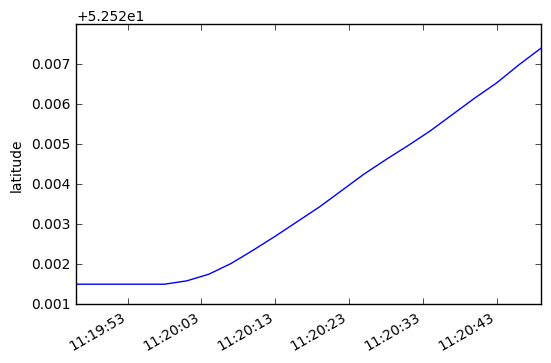

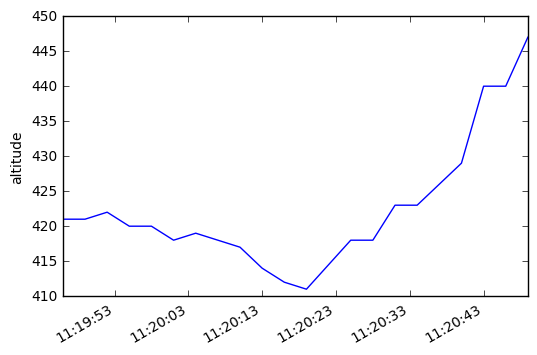

In [6]:
# proof Darren went down 15m, and was takeoff for first 40secs of flight
plt.figure()
(i1.lat.iloc[180:200]).plot()
plt.ylabel("latitude")
plt.figure()
i1.altb.iloc[180:200].plot();
plt.ylabel("altitude")

In [11]:
# Load the positions and difference to next segment
T = pandas.DataFrame({"x":i1.lng, "y":i1.lat, "z":i1.altb})
T["dx"] = T.x.shift(-1) - T.x
T["dy"] = T.y.shift(-1) - T.y
T["dz"] = T.z.shift(-1) - T.z
T["t"] = T.index
T["dt"] = T.t.shift(-1) - T.t


In [12]:
# fancy code which works out the previous crossing of a segment
def Fcrossing(pi, Ti):
    # find all the cuts with the axis of this i-segment
    dperp = pi.x*pi.dy - pi.y*pi.dx
    Tpd = Ti.x*pi.dy - Ti.y*pi.dx - dperp
    Tc = Ti[(Tpd<0) != (Tpd.shift(-1)<0)].copy()
    
    # find the cut point of the candidate segments against the i-segment
    Tc["pd"] = Tpd
    Tc["pd1"] = Tpd.shift(-1)
    Tc["lam"] = -Tc.pd/(Tc.pd1 - Tc.pd)
    Tc["clockwise"] = (Tc.pd>0)
    Tc["xc"] = Tc.x + Tc.dx*Tc.lam
    Tc["yc"] = Tc.y + Tc.dy*Tc.lam

    dp = pi.x*pi.dx + pi.y*pi.dy
    dlensq = pi.dx**2 + pi.dy**2

    Tc["clam"] = (Tc.xc*pi.dx + Tc.yc*pi.dy - dp)/dlensq
    Tcc = Tc[(Tc.clam>0) & (Tc.clam<1)]
    if len(Tcc) == 0:
        return None
    pic = Tcc.max(axis=0)
    # pic.x+pic.dx*pic.lam should equal: pi.x+pi.dx*pic.clam
    crossing = {"cx": pic.x+pic.dx*pic.lam, "cy": pic.y+pic.dy*pic.lam, 
                "t0":pic.t+pic["dt"]*pic.lam, "z0":pic.z+pic.dz*pic.lam, 
                "t1":pi.t+pi["dt"]*pic.clam, "z1":pi.z+pi.dz*pic.clam, 
                "clockwise":pic.clockwise
               }
    return crossing
    

In [13]:
crossings = [ ]
for i in range(200, len(T)-200, 1):
    c = Fcrossing(T.iloc[i], T.iloc[max(200, i-300):i-2])
    if c:
        crossings.append(c)
    
len(crossings)    

721

In [14]:
# database of all crossings (and previous crossing)
pc = pandas.DataFrame.from_dict(crossings)
pc["t1p"] = pc.t1.shift(1)
pc["z1p"] = pc.z1.shift(1)
pc["t1n"] = pc.t1.shift(-1)
pc = pc.iloc[1:-1]

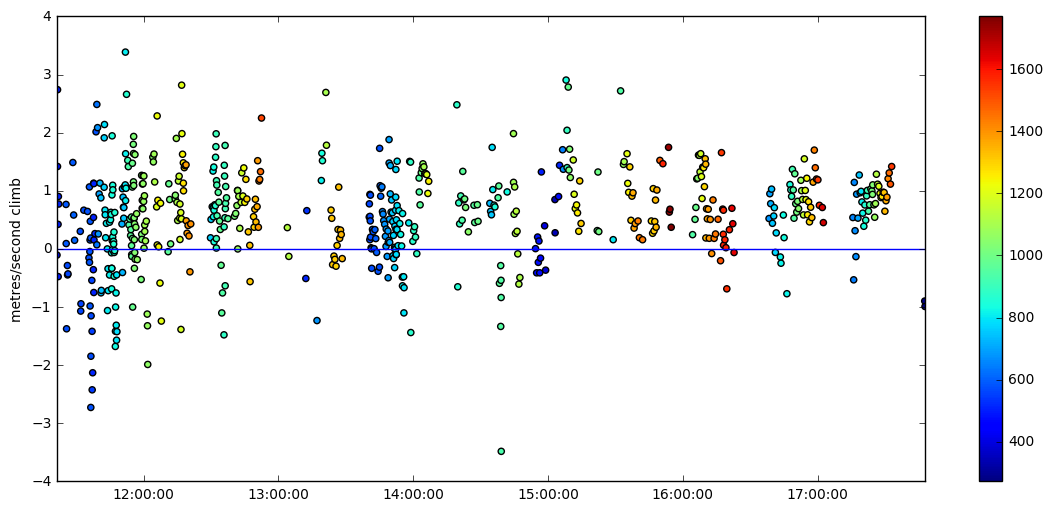

In [23]:
s1 = pandas.Timedelta(seconds=1)
spc = pc[(pc.t1-pc.t1p)<pandas.Timedelta(seconds=40)]
len(spc)
#((pc.t1-pc.t1p)/s1).plot()
plt.figure(figsize=(14,6))
zd = (spc.z1 - spc.z1p)/((spc.t1-spc.t1p)/s1)
plt.scatter(list(spc.t1), zd, c=spc.z1)
plt.xlim((min(spc.t1), max(spc.t1)))
plt.colorbar()
plt.plot((min(spc.t1), max(spc.t1)), [0,0])
plt.ylabel("metres/second climb")

In [175]:
# Seek out isolated self-crossing turns (often not in a thermal)
# to detect turns that were mistakes (+1 for BST if you look on http://www.livetrack24.com/track/952754 )
s1 = pandas.Timedelta(seconds=1)
isolationtime = pandas.Timedelta(seconds=40)
ipc = pc[((pc.t1-pc.t1p)>isolationtime) & ((pc.t1n-pc.t1)>isolationtime)].copy()
ipc["dt"] = ipc.t1 - ipc.t0
ipc["sink_rate"] = (ipc.z1 - ipc.z0)/(ipc.dt/s1)
ipc[["t0", "dt", "z0", "z1", "sink_rate"]]

,t0,dt,z0,z1,sink_rate
8,2017-08-15 11:24:01.454455445,00:00:14.661386,534.545545,553.038614,1.261345
257,2017-08-15 12:37:44.374732334,00:00:39.997858,972.458244,986.000000,0.338562
258,2017-08-15 12:38:36.723965763,00:00:33.579885,985.723966,984.000000,-0.051339
294,2017-08-15 13:04:50.270676691,00:00:28.827067,1116.000000,1113.203008,-0.097027
300,2017-08-15 13:17:49.853333333,00:00:10.271111,736.097778,748.122963,1.170777
322,2017-08-15 13:29:50.515837104,00:00:14.617194,1247.031674,1266.133032,1.306773
323,2017-08-15 13:30:32.846534653,00:00:12.816831,1254.257426,1269.554455,1.193511
324,2017-08-15 13:33:52.652413793,00:00:30.593793,1107.884138,1087.164138,-0.677262
426,2017-08-15 14:07:08.214833759,00:00:35.493606,1271.286445,1311.764706,1.140438
427,2017-08-15 14:07:50.466732380,00:00:40.303104,1310.519961,1334.820108,0.602935


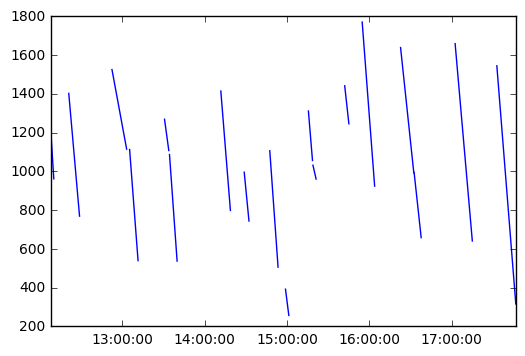

In [60]:
# detect all 2 minute glides
glidetime = pandas.Timedelta(seconds=120)
gpc = pc[((pc.t0-pc.t1p)>glidetime) & (pc.z1p>pc.z0)]

for g in gpc.itertuples():
    plt.plot([g.t1p, g.t0], [g.z1p, g.z0], color="b")


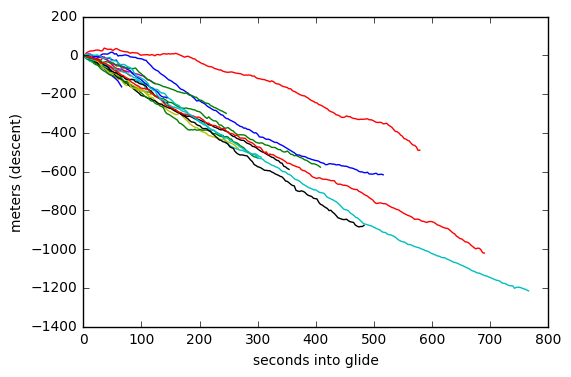

In [97]:
# plot the relative sink line of each glide
trimtime = pandas.Timedelta(seconds=30)
for g in gpc.itertuples():
    Tg = T[g.t1p+trimtime:g.t0-trimtime]
    Tg0 = Tg.iloc[0]
    plt.plot((Tg.t-Tg0.t)/1.0e9, Tg.z-Tg0.z)
plt.ylabel("meters (descent)")
plt.xlabel("seconds into glide")

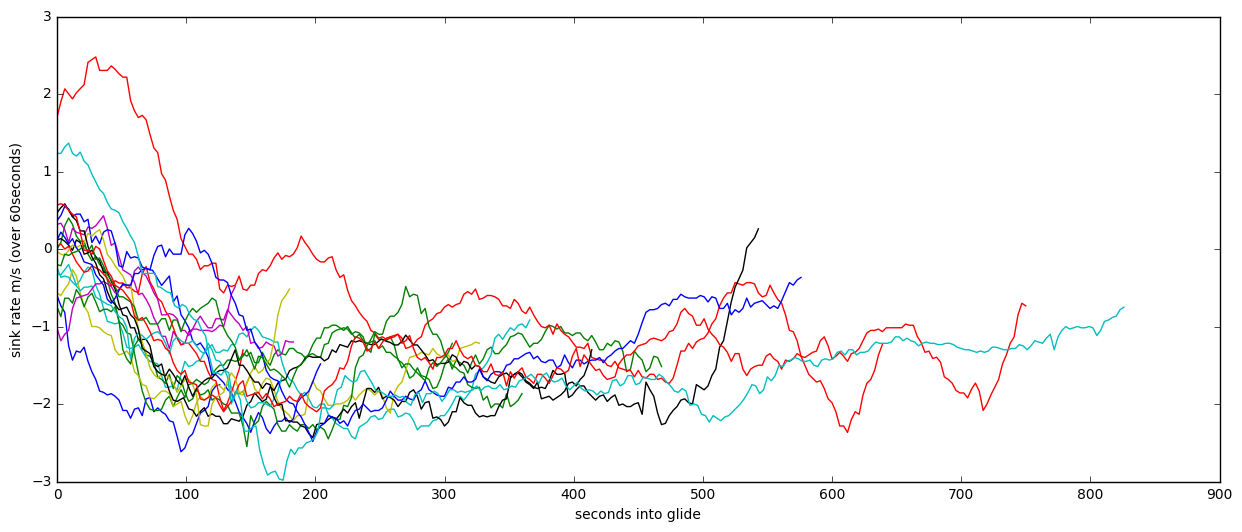

In [101]:
# plot the relative sink line of each glide
plt.figure(figsize=(15,6))
trimtime = pandas.Timedelta(seconds=0)
for g in gpc.itertuples():
    Tg = T[g.t1p+trimtime:g.t0-trimtime]
    Tg0 = Tg.iloc[0]
    Tgsh = T.shift(20)[g.t1p+trimtime:g.t0-trimtime]
    plt.plot((Tg.t-Tg0.t)/1.0e9, (Tg.z-Tgsh.z)/((Tg.t-Tgsh.t)/s1))
    
plt.ylabel("sink rate m/s (over 60seconds)")
plt.xlabel("seconds into glide")

### Trimtime set to 0 to see the return to zero sink at end of glides

### Big sink rates of -2m/s did actually occur for 1 minute durations.  

### But to relate to speed I'd need to convert the lat-longs into metres position and take account of wind direction vector.  

## Now to look at the getting away from the hill experience


In [114]:
# dog's breakfast of an over the back track seen here: http://www.livetrack24.com/track/952778

i2 = GLoadIGC("JulianTodd 2017-08-15 12_22_13.igc")
J = pandas.DataFrame({"x":i2.lng, "y":i2.lat, "z":i2.altb})


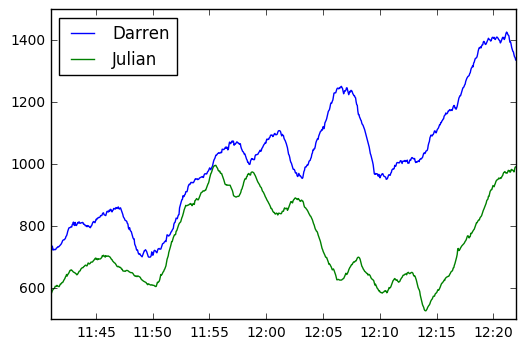

In [168]:
import matplotlib.dates
t0, t1 = T.index[400], T.index[400]+pandas.Timedelta(minutes=70)
t0, t1 = pandas.Timestamp("2017-08-15 11:41:00"), pandas.Timestamp("2017-08-15 12:22:00")
plt.plot(T.z[t0:t1], label="Darren")
plt.plot(J.z[t0:t1], label="Julian")
plt.axes().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
plt.legend(loc=2)


In [169]:
# find position relative to each other.  This requires interpolation, which is hard
import numpy
def InterpT(seriestime, seriesother, dts=0):
    vals = numpy.interp(seriestime.index.asi8, seriesother.index.asi8+int(dts*1e9), seriesother)
    return pandas.Series(vals, seriestime.index)

import math
earthrad = 6378137
nyfac = 2*math.pi*earthrad/360
exfac = nyfac*math.cos(math.radians(T.iloc[0].x))

Ts = T[t0:t1]
JT = pandas.DataFrame({"x":InterpT(Ts, J.x), "y":InterpT(Ts, J.y), "z":InterpT(Ts, J.z)}) 
vx = (Ts.x - JT.x)*exfac
vy = (Ts.y - JT.y)*nyfac

horizontaldistance = numpy.sqrt(vx**2 + vy**2)


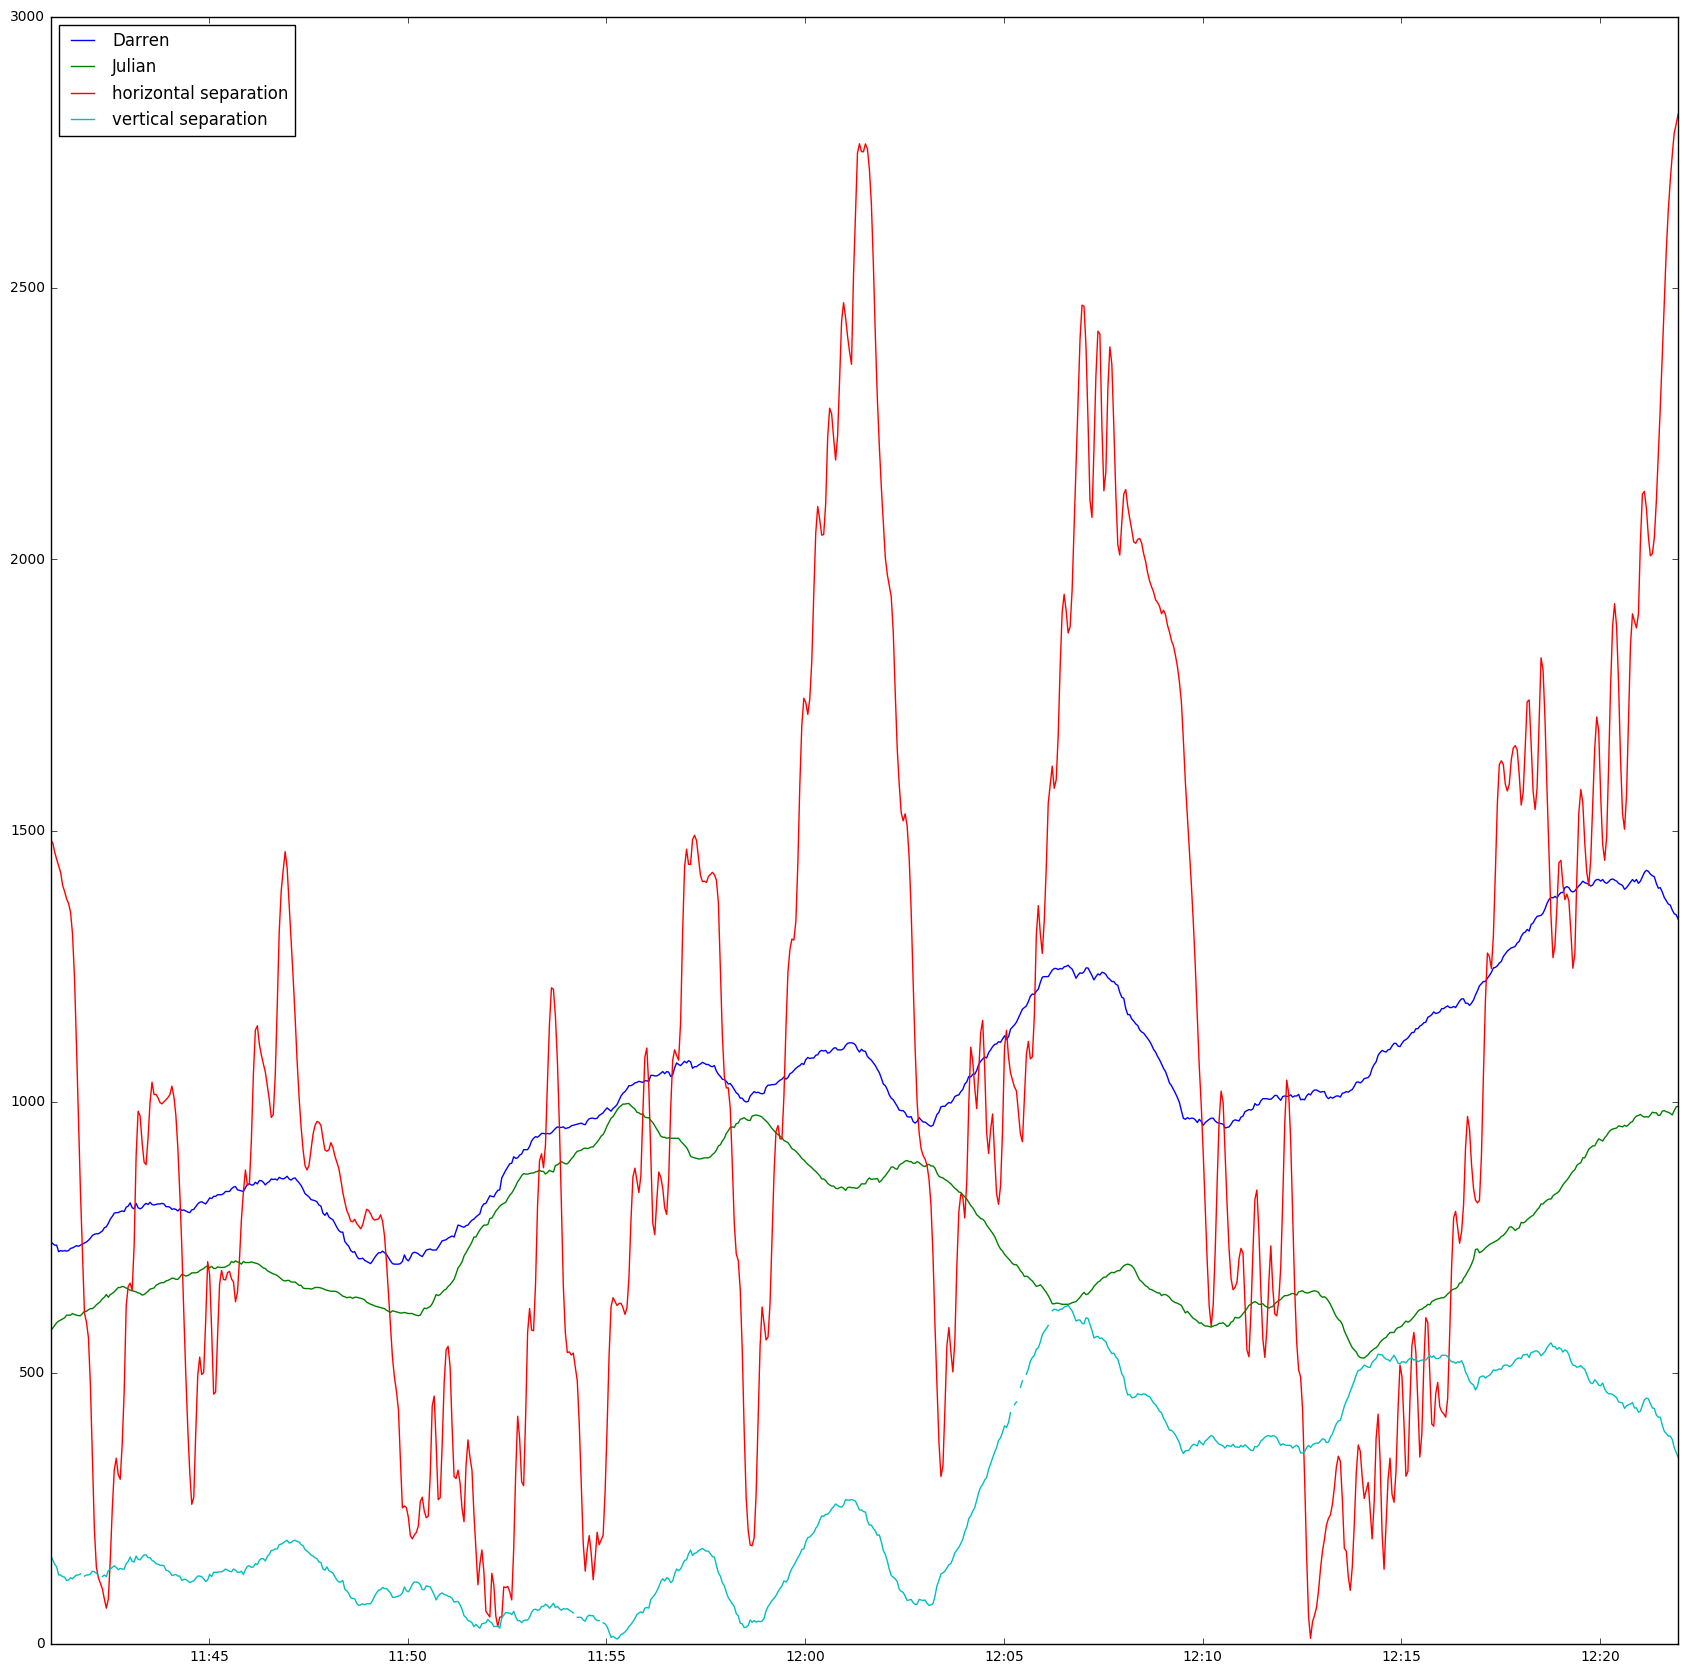

In [174]:
plt.figure(figsize=(21,21))
plt.plot(T.z[t0:t1], label="Darren")
plt.plot(J.z[t0:t1], label="Julian")
plt.axes().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
plt.plot(horizontaldistance, label="horizontal separation")
plt.plot(T.z[t0:t1]-J.z[t0:t1], label="vertical separation")
plt.legend(loc=2)


In [ ]:
# The closest approaches were with Darren below me (not evident in the data)

# Julian did not follow thermals back, hence sank as Darren's horizontal distance moved up

# eventual departure from the hill was while in same thermal climbing at same rate but
# with 500m vertical separation